# Prerequisites
conda install graphviz pygraphviz -c alubbock

Perform *dot -c* in conda prompt

# Content
This notebook uses tree data (structured as CSV) which is generated by Christian Koch:
* https://github.com/c4ristian/collatz/tree/v1.3.2
* https://github.com/c4ristian/collatz/blob/v1.3.2/collatz/graph.py
* https://github.com/c4ristian/collatz/blob/v1.3.2/tests/test_graph.py
* https://github.com/c4ristian/collatz/blob/v1.3.2/notebooks/dutch_graph.md

These trees are visualized using networkx.

In [14]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

In [15]:
df = pd.read_csv("dutch_graph_t_0.csv", skip_blank_lines=True, header=0)
df.drop(df.columns[0], axis=1, inplace=True)

In [16]:
G = nx.from_pandas_edgelist(df, 'successor', 'predecessor', create_using=nx.DiGraph)

In [17]:
# in case of error see: https://stackoverflow.com/questions/15661384/python-does-not-see-pygraphviz
# run !sudo apt-get install graphviz libgraphviz-dev pkg-config
# !pip install pygraphviz
pos=graphviz_layout(G, prog='dot')

In [18]:
list(nx.selfloop_edges(G))

[(1, 1)]

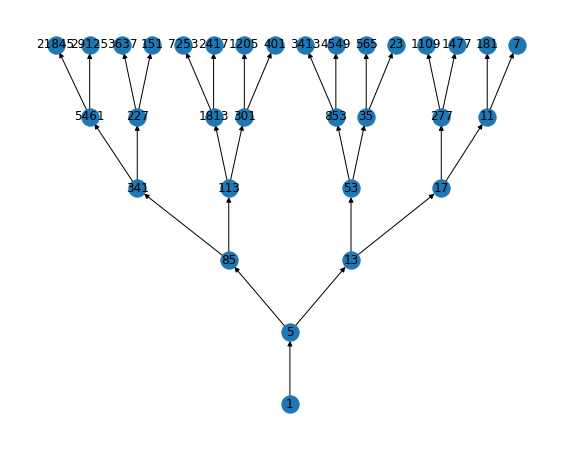

In [19]:
plt.figure(figsize=(10, 8))
plt.gca().invert_yaxis()
nx.draw(G, with_labels=True, arrows=True, pos=pos)